In [6]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import sys
import os

# Add path to vim.py
sys.path.append("../utils")
from vim import ViM

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained ResNet18
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 1)
model.load_state_dict(torch.load("../models/resnet18_id_only.pth", map_location=device))
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

id_path = r"D:\ODD PROJECT\DATA\BDD\scene_classification\id"
id_dataset = datasets.ImageFolder(root=id_path, transform=transform)
id_loader = DataLoader(id_dataset, batch_size=32, shuffle=False)


In [8]:
# Initialize ViM
vim = ViM(model, layer_name="avgpool")  # 'avgpool' is the layer before fc

# Step 3a: Extract features and logits from ID training set
id_features, id_logits = vim.extract_features(id_loader, device)

# Step 3b: Fit PCA basis and compute alpha
vim.fit(id_features)
vim.compute_alpha(id_features, id_logits)

print("✅ ViM fitted successfully on ID features.")


✅ ViM fitted successfully on ID features.


In [12]:
# === Load ID test set ===
id_test_path = r"D:\ODD PROJECT\DATA\BDD\scene_classification\id"
id_test_dataset = datasets.ImageFolder(root=id_test_path, transform=transform)
id_test_loader = DataLoader(id_test_dataset, batch_size=1, shuffle=False)

# === Load OOD test set ===
ood_path = r"D:\ODD PROJECT\DATA\BDD\scene_classification\ood"
ood_dataset = datasets.ImageFolder(root=ood_path, transform=transform)
ood_loader = DataLoader(ood_dataset, batch_size=1, shuffle=False)

# === Extract features and logits ===
id_test_features, id_test_logits = vim.extract_features(id_test_loader, device)
ood_features, ood_logits = vim.extract_features(ood_loader, device)

# === Compute ViM scores ===
id_scores = vim.get_vim_score(id_test_features, id_test_logits)
ood_scores = vim.get_vim_score(ood_features, ood_logits)


np.save("../results/id_scores_vim.npy", id_scores)
np.save("../results/ood_scores_vim.npy", ood_scores)


print(f"✅ ViM scores computed: {len(id_scores)} ID and {len(ood_scores)} OOD samples")


✅ ViM scores computed: 251 ID and 634 OOD samples


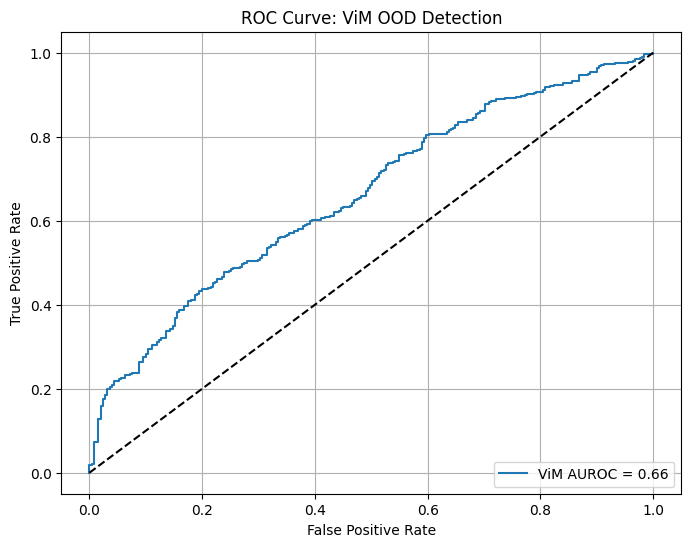

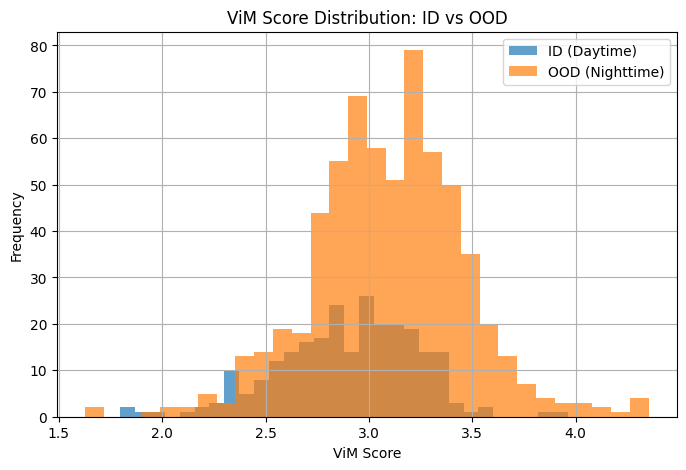

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# === Prepare labels: 0 for ID, 1 for OOD ===
labels = np.array([0] * len(id_scores) + [1] * len(ood_scores))
scores = np.concatenate([id_scores, ood_scores])

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# === Plot ROC Curve ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ViM AUROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: ViM OOD Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# === Plot Score Distributions ===
plt.figure(figsize=(8, 5))
plt.hist(id_scores, bins=30, alpha=0.7, label='ID (Daytime)')
plt.hist(ood_scores, bins=30, alpha=0.7, label='OOD (Nighttime)')
plt.xlabel('ViM Score')
plt.ylabel('Frequency')
plt.title('ViM Score Distribution: ID vs OOD')
plt.legend()
plt.grid(True)
plt.show()
